[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module2_Files/2_HotAndCold.ipynb)

# Hot and Cold Learning, Convergence and Divergence

-----------------------------------------

**Dr. Dave Wanik**

The purpose of this notebook is to show you what backpropagation is - an efficient way of updating the weights in a neural network! For simplicity, we will only learn one row of the dataset (for now) - but later on, you will learn how to build a model that generalizes and updates its weights such thaat it can predict an entire dataset!

In [ ]:
# get some important modules
import pandas as pd # for data wrangling
import numpy as np # for array calculations, some math functions
from matplotlib import pyplot as plt #for plotting
import seaborn as sns

In [ ]:
# some modules for neural nets
from keras.models import Sequential
from keras.layers import Dense

# Read and Prepare Data

In [ ]:
# # step 1: copy & paste the shared link you will get from Google Drive
# URL = 'https://drive.google.com/file/d/1n6FQNPUIt37bp0Secg8Akgxm0B1uiEo3/view?usp=sharing'

# # step 2: copy & paste the command below (this part of the command is fixed)
# fixed_path = 'https://drive.google.com/uc?export=download&id='

# # step 3: Extract the file ID from the URL (this part of the command is fixed)
# file_path = URL.split('/')[-2]

# # retrieve the CSV data and build a dataframe
# df = pd.read_csv(fixed_path + file_path)

# # print the shape and dataset info
# print(df.shape)
# df.info()

(14, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Day       14 non-null     int64
 1   Temp      14 non-null     int64
 2   Humidity  14 non-null     int64
 3   Wind      14 non-null     int64
 4   Play      14 non-null     int64
dtypes: int64(5)
memory usage: 688.0 bytes


In [ ]:
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module2_Files/Tennis%20Binary%20Classification.csv"

# retrieve the CSV data and build a dataframe
df = pd.read_csv(url)

# print the shape and dataset info
print(df.shape)
df.info()

(14, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Day       14 non-null     int64
 1   Temp      14 non-null     int64
 2   Humidity  14 non-null     int64
 3   Wind      14 non-null     int64
 4   Play      14 non-null     int64
dtypes: int64(5)
memory usage: 692.0 bytes


This dataset is similar to the one before - but look at the target variable! It's now 0s and 1s... which means we are looking at a classification problem.

In [ ]:
# show top 5 rows
df.head()

,Day,Temp,Humidity,Wind,Play
0,1,82,54,20,0
1,2,71,54,6,0
2,3,81,61,11,1
3,4,50,65,15,1
4,5,52,71,23,1


In [ ]:
# the 0s and 1s mean that we are looking at a binary classification problem
df['Play'].value_counts()

1    9
0    5
Name: Play, dtype: int64

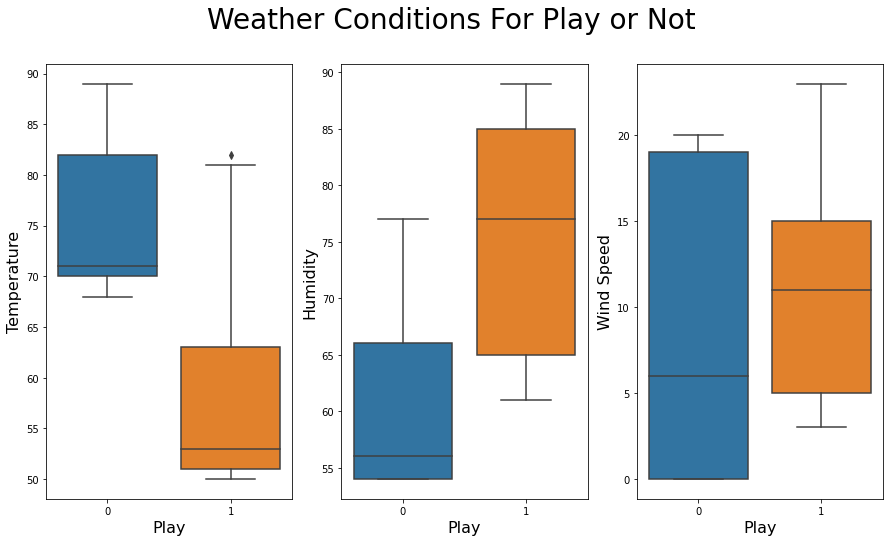

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8)) # create subplot
fig.suptitle('Weather Conditions For Play or Not', fontsize=28) # set the title for this plot

sns.boxplot(ax=axes[0], x="Play", y="Temp", data=df) # plot the box plot of temperature
axes[0].set_xlabel('Play', fontsize=16) # x label
axes[0].set_ylabel('Temperature', fontsize=16) # y label

sns.boxplot(ax=axes[1], x="Play", y="Humidity", data=df) # plot the box plot of humidity
axes[1].set_xlabel('Play', fontsize=16) # x label
axes[1].set_ylabel('Humidity', fontsize=16) # y label

sns.boxplot(ax=axes[2], x="Play", y="Wind", data=df) # plot the box plot of wind speed
axes[2].set_xlabel('Play', fontsize=16) # x label
axes[2].set_ylabel('Wind Speed', fontsize=16) # y label

plt.show() # show the plot

We can see that people will play if the temperature is lower and the humidity is higher. Let's see if the model can learn this pattern, too!

# Gradient Descent

Three fundamental steps to fitting a neural network:
*   **Predict** ➡ We have covered the concept in the previous forward propagation notebook. We are experts at making a prediction!
*   **Compare** ➡ What was the error between actual and predicted
  *   A measurement of how much our prediction **"missed"**.
  *   Once a prediction is made, the next step is to evaluate how well we did.
  *   There are many properties of **"measuring error"** that you have likely been doing your whole life without realizing it. Perhaps you amplify larger errors while ignoring very small ones (as is the case with squared error.)
*   **Learn** ➡ Updating the weights to make a more accurate prediction.
  *   "Learning" takes our error and tells each weight how it can change to reduce it.
  *   Learning is all about **"error attribution"**, or the art of figuring out how each weight played its part in creating error. It is the "blame game" of neural networks – more officially, it is called **“gradient descent”**.
  *   At the end of the day, it is going to result in computing a number for each of our weights. That number will represent how that weight should be higher or lower in order to reduce the error. Then we will move the weight according to that number, and we will be done.




## Compare: Does our network make good predictions?
Let's look at an example of how we evaluate how well a model fits!

In [ ]:
# speficy an arbitrary value for weight
knob_weight = 0.005

input = df['Temp'].tolist()[0] # convert temperature to list and select first value
# target variable
goal_pred = 0

# make a prediction
pred = input * knob_weight
print('this is my prediction:', pred)

# evaluate the error
sq_error = (pred - goal_pred) ** 2 # force the raw error to be positive by squaring (multiplying by itself)
print('this is my squared error:', sq_error) # squared error

this is my prediction: 0.41000000000000003
this is my squared error: 0.16810000000000003


💡 **The goal of training the neural network is to make correct predictions. Measuring error is the key to simplifies this challenge. The error is a way to measure how much you missed. It is the signal we will use to update the weights.**

# Convergence: Hot and Cold Learning

To demonstrate how error is a signal to learn on, adjusting the weight either up or down so the error is reduced (similar to raising or lowering temperature). It is simple but effective.

We wiggle our weights to see which direction reduces the error the most, moving our weights in that direction, and repeating until the error gets to 0.

## ... a little colder...

In [ ]:
# COMPARE: Making A Prediction With a *Lower* Weight And Evaluating Error

weight = 0.004 # a little smaller than 0.005

def neural_network(input, weight):
    prediction = input * weight
    return prediction

temp = df['Temp'].tolist() # convert temperature to list
play_binary = df['Play'].tolist() # convert temperature to list

input = temp[0] # 82 degF
true = play_binary[0] # no one played golf, it's a zero!

pred = neural_network(input,weight)
print('prediction:', pred) # 32% chance of playing golf
sq_error = (pred - true) ** 2
print('sq error:', sq_error)

prediction: 0.328
sq error: 0.10758400000000001


## ... a little warmer...

In [ ]:
# COMPARE: Making A Prediction With a *Higher* Weight And Evaluating Error

weight = 0.006 # a little bigger than 0.005

def neural_network(input, weight):
    prediction = input * weight
    return prediction

temp = df['Temp'].tolist() # convert temperature to list
play_binary = df['Play'].tolist() # convert temperature to list

input = temp[0]
true = play_binary[0]

# we want to move the weight so the error goes down
p_up = neural_network(input,weight)
print('prediction:', p_up) # 49% chance of playing golf
e_up = (p_up - true) ** 2
print('sq error:', e_up)

prediction: 0.492
sq error: 0.242064


Clearly, the lower weight makes a more accurate prediction (closer to actual value of zero.) Instead of turning the knob a little bit manually, can we code all of this into a for loop? Yes, of course we can!

## Goldilocks - we got it 'just right'!
Can we get it just right by using a for loop? Let's try!

* https://en.wikipedia.org/wiki/Goldilocks_and_the_Three_Bears

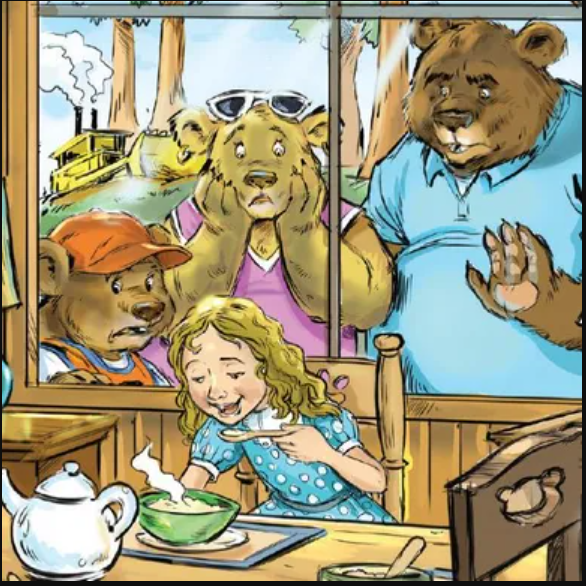

In [ ]:
# hot and cold learning is the simplest form of learning.
weight = 0.005
input = 82 # first row in the dataset
goal_prediction = 0

step_amount = 0.00001 # how much to move the weights each iteration

my_results = []
my_weight = []
for iteration in range(1000): # we loop 1k times so that the error can keep getting smaller

    prediction = input * weight
    error = (prediction - goal_prediction) ** 2

    print("Error:" + str(error) + " Prediction:" + str(prediction))

    up_prediction = input * (weight + step_amount) # try go up
    up_error = (goal_prediction - up_prediction) ** 2

    down_prediction = input * (weight - step_amount) # try go down
    down_error = (goal_prediction - down_prediction) ** 2

    if(down_error < up_error): # if down is better, then go down
        weight = weight - step_amount

    if(down_error > up_error): # if up is better, then go up
        weight = weight + step_amount
    my_results.append(error)
    my_weight.append(weight)

Error:0.16810000000000003 Prediction:0.41000000000000003
Error:0.16742827240000002 Prediction:0.40918000000000004
Error:0.16675788960000004 Prediction:0.40836000000000006
Error:0.16608885160000011 Prediction:0.4075400000000001
Error:0.1654211584000001 Prediction:0.40672000000000014
Error:0.1647548100000001 Prediction:0.40590000000000015
Error:0.16408980640000018 Prediction:0.4050800000000002
Error:0.16342614760000018 Prediction:0.40426000000000023
Error:0.16276383360000024 Prediction:0.4034400000000003
Error:0.16210286440000024 Prediction:0.4026200000000003
Error:0.16144324000000027 Prediction:0.4018000000000003
Error:0.16078496040000032 Prediction:0.4009800000000004
Error:0.16012802560000033 Prediction:0.4001600000000004
Error:0.15947243560000032 Prediction:0.3993400000000004
Error:0.1588181904000004 Prediction:0.3985200000000005
Error:0.1581652900000004 Prediction:0.3977000000000005
Error:0.15751373440000044 Prediction:0.39688000000000057
Error:0.15686352360000047 Prediction:0.396060

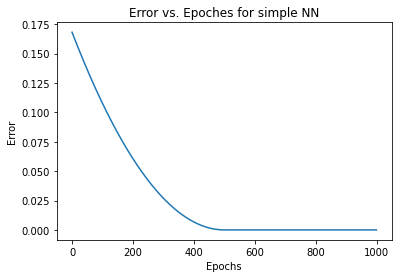

In [ ]:
# we can see the model finds the answer around 450
# clearly, there are some extra runs without any benefit
plt.plot(my_results)
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('Error vs. Epoches for simple NN')
plt.show()

We can find the optimal value after about 400 epochs. But is there a better way?

## Characteristics of hot and cold learning

1. It is inefficient.
2. It is impossible to predict the exact goal prediction.

❗The real problem here is that even though we know the correct direction to move our weight, we do not know the correct amount. Since we do not know the correct amount, we just pick a fixed one at random (step_amount).

Fortunately, this iteration got us pretty close to the correct answer all by itself (the new error is only 0.004). However, under normal circumstances, we would have to repeat this process many times in order to find the correct weights.
Some people even have to train their networks for weeks or months before they find a good enough weight configuration.
This reveals what learning in neural networks really is. It's a search problem. We are searching for the best possible configuration of weights so that our network's error falls to zero (and predicts perfectly).

# Convergence: Calculating Direction and Amount from Error

*   **direction_and_amount**: It represents how you want to change weight. The first part is what I call pure error, which equals (pred - goal_pred).The
second part is the multiplication by the input that performs scaling, negative reversal, and stopping, modifying the pure error so it’s ready to update weight.
*   **Pure Error**: It indicates the raw direction and amount you missed. If this is a positive number, you predicted too high, and vice versa. If this is a big number, you missed by a big amount, and so on.
*   **Scaling, Negative and Stopping**: These three attributes have the combined effect of translating the pure error into the absolute amount you want to change weight. They do so by addressing three major edge cases where the pure error isn’t sufficient to make a good modification to weight.
*   **Stopping**: Stopping is the first effect on the pure error caused by multiplying it by input. Stopping addresses this in a neural network. If input is 0, then it will force direction_and_amount to also be 0. You do not learn (change the volume) when input is 0, because there is nothing to learn. Every weight value has the same error, and moving it makes no difference because pred is always 0.

## Updating the weight with `direction_and_amount` and a learning rate (alpha)

Look at the code and make sure this makes sense before moving on.

The learning rate helps ensure the model isn't learning too quickly - if it does, it may get stuck in a suboptimal value for the weight, or you might experience 'divergence' (to be shown next)! The `direction_and_amount` helps you update the weight proportional to the size of the error and the size of the input.

I always tell my students to memorize this code snippet and remember "PEDW" when they are thinking about how to update a neural network:
* **P** for prediction
* **E** for error (squared error, used for tracking model fit - we use squared error because it penalizes large outliers)
* **D** for direction and amount (or derivative). Direction and amount is predicted minus actual. A positive value means you overestimated. A negative value means you underestimated.
* **W** for weight update (the new weight is created by updating the old weight by i) the direction and amount of the error, as well as the input). With the `weight = weight - direction_and_amount*lr` code, we see that the weight will get bigger if we previously underestimated and that it will get smaller if the model underestimated!

In [ ]:
weight = 0.005
goal_pred = 0 # first row in the dataset
input = 82 # first row in the dataset
lr = 0.00001 # a learning rate (alpha) can help slow things down - choose a small value!

my_results = [] # an empty place to store the error
for iteration in range(100):
    pred = input * weight
    error = (pred - goal_pred) ** 2
    direction_and_amount = (pred - goal_pred) * input
    weight = weight - direction_and_amount*lr

    print("Error:" + str(error) + " Prediction:" + str(pred))
    my_results.append(error)

Error:0.16810000000000003 Prediction:0.41000000000000003
Error:0.14625392867856 Prediction:0.3824316
Error:0.1272469461862779 Prediction:0.356716899216
Error:0.11071008799579089 Prediction:0.33273125491271616
Error:0.09632233976046106 Prediction:0.3103584053323851
Error:0.08380440576727242 Prediction:0.28948990615783554
Error:0.07291328723400217 Prediction:0.2700246048677827
Error:0.06343756520428978 Prediction:0.251868150436473
Error:0.055193296471919666 Prediction:0.23493253600112451
Error:0.048020442865786765 Prediction:0.2191356722804089
Error:0.041779764580640345 Prediction:0.20440098967627418
Error:0.03635011724678168 Prediction:0.1906570671304415
Error:0.03162610026929268 Prediction:0.1778372859365906
Error:0.02751601078623509 Prediction:0.16587950683021424
Error:0.02394006352795072 Prediction:0.15472576879095065
Error:0.02082884202127959 Prediction:0.1443220080974471
Error:0.01812195107339214 Prediction:0.13461779627297477
Error:0.015766844377181725 Prediction:0.125566095651579

The error goes down with each iteration :)

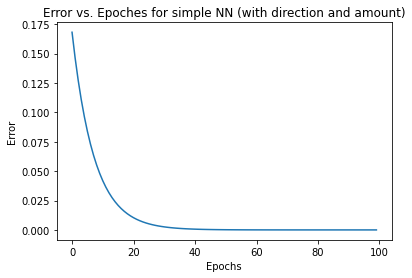

In [ ]:
# we can see the model finds the answer around 150000
# clearly, there are some extra runs without any benefit
plt.plot(my_results)
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('Error vs. Epoches for simple NN (with direction and amount)')
plt.show()

**Tada!** We learned it in about 30 epochs... that's a lot faster and better than the 400 it took to converge before with hot and cold learning! If we used a larger learning rate, we would likely learn even faster!

## Why do we need negative reversal?
Check out this image of various values of weights (X axis) vs. the squared error (Y axis).

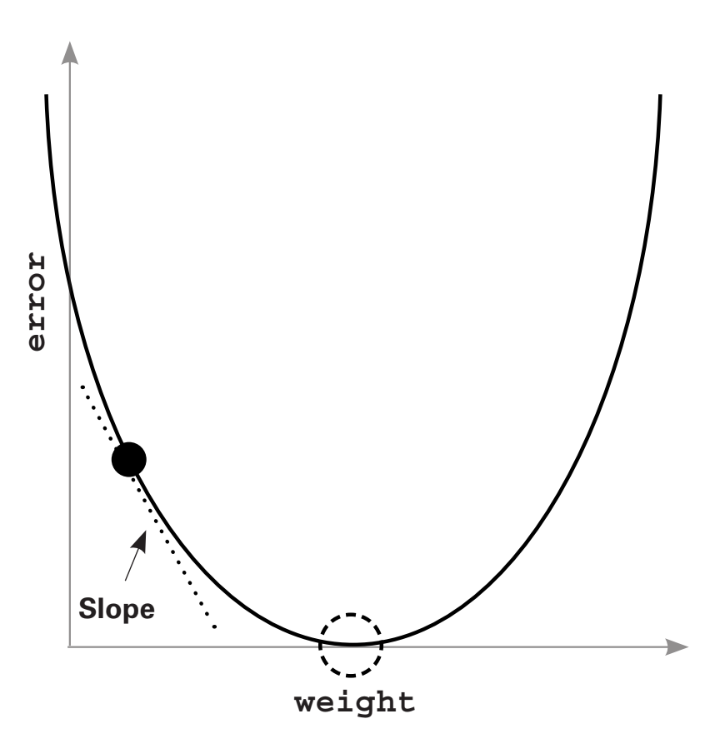

Note the scale of the Y axis and look at the print out - we can get lost VERY QUICKLY if we take too big of a step!

* This graph represents every value of error for every weight according to the relationship in the formula above. Notice it makes a nice bowl shape (this is because the Y axis is the squared error - it's a parabola!)

* The black "dot" is at the point of BOTH our current weight and error. The dotted "circle" is where we want to be (error == 0).

* The slope points to the bottom of the bowl (lowest error) no matter where you are in the bowl. You can use this slope to help the neural network reduce the error.

**On Your Own:** Try to recreate the image from the book with code! Pick values from -5 to positive 5 with a step size of 0.001. Email Dave or post on the discussion board if you do it!

## How to use a Derivative to Learn

What’s the difference between error and the derivative of error and weight? Error is a measure of how much you missed. The derivative defines the relationship between each weight and how much you missed. In other words, it tells how much changing a weight contributed to the error.

The slope of a line or curve always points in the opposite direction of the lowest point of the line or curve. So, if you have a negative slope, you increase weight to find the minimum of error.

You’re trying to figure out the direction and the amount to change the weight so the error goes down. A derivative gives you the relationship between any
two variables in a function. You use the derivative to determine the relationship between any weight and error. You then move the weight in the opposite direction of the derivative to find the lowest weight. The neural network learns!

This method for learning (finding error minimums) is called **gradient descent**. This name should seem intuitive. You move the weight value opposite the gradient value, which reduces error to 0. By opposite, you increase the weight when you have a negative gradient, and vice versa.

💡There are a few types of gradient descent (stochastic: update the weights after every data sample, batch: update the weights after tracking the error for X observations, and full: update the weights after you evaluate the performance of the model on the ENTIRE dataset) - which you get to choose from as the modeler! Each has its own flavor and you'll learn about them next.

# Divergence (what happens when you use no learning rate or a big learning rate)
Look what happens with the same example if we don't moderate the learning... we can get lost VERY QUICKLY! The weights are overcorrecting too much with each iteration...

In [ ]:
weight = 0.005
goal_pred = 0 # first row in the dataset
input = 82 # first row in the dataset

my_results = [] # an empty place to store the error
for iteration in range(10):
    pred = input * weight
    error = (pred - goal_pred) ** 2
    # 1. pure error = pred - goal_pred
    # 2. scaling, negative reversal and stopping
    direction_and_amount = (pred - goal_pred) * input
    weight = weight - direction_and_amount #*lr learning rate is gone!

    print("Error:" + str(error) + " Prediction:" + str(pred))
    my_results.append(error)

Error:0.16810000000000003 Prediction:0.41000000000000003
Error:7597906.344900002 Prediction:-2756.4300000000003
Error:343415709850515.6 Prediction:18531478.89
Error:1.5521953603876087e+22 Prediction:-124587132577.47
Error:7.015725744921687e+29 Prediction:837599292318330.9
Error:3.171018866830384e+37 Prediction:-5.631180042256138e+18
Error:1.4332602241575365e+45 Prediction:3.785842342408802e+22
Error:6.478154045817571e+52 Prediction:-2.545221806801437e+26
Error:2.92804329137162e+60 Prediction:1.711152620712606e+30
Error:1.323438352269739e+68 Prediction:-1.1504079069050851e+34


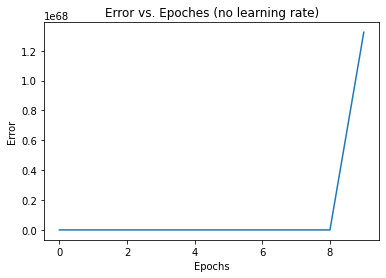

In [ ]:
# we can see the model finds the answer around 150000
# clearly, there are some extra runs without any benefit
plt.plot(my_results)
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('Error vs. Epoches (no learning rate)')
plt.show()

**On your own:** You can re-run with the learning rate to help the model converge nicely!

## A more formal definition of divergence

**Divergence means breaking gradient descent**. The explosion in the error was caused by the fact that you kept making the input larger. If the input is sufficiently large, this can make the weight update large even when the error is small. What happens when you have a large weight update and a small error? The network overcorrects. If the new error is even bigger, the network overcorrects even more!

The solution to divergence is to multiply the weight update by a fraction to make it smaller. In most cases, this involves multiplying our weight update by a single real-valued number between 0 and 1, known as alpha.

Finding the appropriate alpha, even for state-of-the-art neural networks, is often done simply by guessing. You watch your error over time. If it starts diverging (going up), then your alpha is too high, and you decrease it. If learning is happening too slowly, then your alpha is too low, and you increase it.


# Summary

Gradient descent is a general learning algorithm. If you combine weights in a way that allows you to calculate an error function and a delta, gradient descent can show you how to move the weights to reduce the error. We’ll spend the rest of this book exploring different types of weight combinations and error functions for which gradient descent is useful.
